## imports

In [1]:
import numpy as np
from numpy import sqrt, abs, pi, exp, diag, mean, min, max, sum, eye
from numpy.linalg import norm, inv
import math
import matplotlib.pyplot as plt
import time

In [2]:
import torch

## function & derivatives

In [3]:
def F03(x):
    # SumOfDifferentPowers
    n = x.shape[0]
    d = x.shape[1]
    f = np.sum(np.abs(x)**(np.arange(1, d+1) + 1), axis = 1)
    return f.astype('float32')

In [4]:
def F03_grad(x):
    d = x.shape[1]
    gradf = (np.arange(1, d+1) + 1).reshape(1,-1) * np.abs(x)**(np.arange(1, d + 1)) * np.sign(x)
    return gradf.astype('float32')

## func, xmean, dim

In [5]:
N = 5000
strfitnessfct = F03
strgrad = F03_grad
xmean = 0.1 * np.ones((N,1)) + 0.01* np.random.randn(N,1)


In [6]:
xmean.shape

(5000, 1)

## initialisations

In [7]:
stopfitness = 1e-3

In [8]:
xmean = xmean.astype('float32')
xmin = xmean

In [9]:
R = 0.1 * np.ones((1,N))
Γ = np.zeros((N,1), dtype = np.float32)
p = 5
cs = 0.1
it = 0
prev = 0
θ = 0.1
Δ = 0
x_st = xmean
fXX = (strfitnessfct(xmean.T))

## helper functions

In [10]:
def generate_arx(x, r, num = 5):
    return np.concatenate([x,x + (r * (2*np.random.rand(num-1, x.shape[0])-1)).T], axis = 1)

In [11]:
def sorted_x_y_grad(x, grads = True):
    if grads == True:
        y = strfitnessfct(x.T)
        y_grad = strgrad(x.T).T
        
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        y_grad_sorted = y_grad[:,sorted_indices]
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]

        return x_sorted, y_sorted[0], y_grad_sorted, fittest
    else:
        y = strfitnessfct(x.T)
        y_sorted = np.sort(y)
        sorted_indices = np.argsort(y)
        x_sorted = x[:, sorted_indices]
        fittest = x_sorted[:,0:1]
        worst = x_sorted[:,-1:]

        return fittest, worst, y_sorted[0]

In [12]:
def calc_invH(x, x_grad, γ = 1):
    a = x - np.mean(x, axis = 1).reshape(-1,1)
    b = x_grad - np.mean(x_grad, axis = 1).reshape(-1,1)
    c = np.sum(a*b, axis = 1)
    d = np.sum(b*b, axis = 1)
    Hinv = (c / d).reshape(-1,1)
    Hinv = np.nan_to_num(Hinv)
    Hinv[Hinv<0] = 0.0
    return Hinv**γ

In [13]:
def cal_R(xmin, xmax, ps, cs = 0.1):
    ps = (1 - cs) * ps + cs * (xmax - xmin)
    sig = np.minimum(np.abs(ps.T), 0.01 * np.ones_like(ps.T))
    sig[sig == 0] = 0.01
    return sig, ps

In [14]:
def update_ensemble(x, α, Δ):
    K = Δ
    x1 = x - α * Δ
    return x1, K

In [15]:
def increment(K, B, G, θ=0.1):
    return θ * K + B * G

In [16]:
def wolfe_step(g, Hg, x, loss):
    
    step = 0.1
    c_1 = 0.001
    pvec = - Hg
    γ = 1.0
    
    while γ > 1e-6:
        new_x = x.reshape(-1,1) + γ * pvec.reshape(-1,1)
        loss_new = strfitnessfct(new_x.T)
        g_new = strgrad(new_x.T)
        min_loss = c_1 * γ * pvec @ g
        armijo = loss_new - loss - min_loss

        if armijo < -0:
            step = γ
            x = new_x.reshape(-1,1)
            break
            
        else:
            γ *= 0.5
        # raise RuntimeError("Backtracking line search failed to converge")

    return step

# FINDER

In [17]:
tic = time.time()
while True:
    
    '''
    sampling around xmean
    '''
    arx = generate_arx(xmin, R)
    '''
    gradient computation and sorting initial ensemble
    '''
    arx_sorted, least_fitness, gradf_sorted, xmiin = sorted_x_y_grad(arx, grads=True)
    
    '''
    diagonal approximation to the stochastic mimic of the inverse Hessian
    '''
    B = calc_invH(arx_sorted, gradf_sorted)
    
    '''
    increment term
    '''
    Δ_sorted = increment(prev, B, gradf_sorted, θ)

    '''
    update ensemble
    '''
    α = wolfe_step(gradf_sorted[:, 0], Δ_sorted[:,0], arx_sorted[:, 0], least_fitness)
    arx_new, prev = update_ensemble(arx_sorted, α, Δ_sorted)
    
    '''
    new ensemble
    '''
    arx_new1 = np.concatenate([arx_new, xmiin], axis = 1)
    
    '''
    search radius update
    '''
    xmin, xmax, min_fitness = sorted_x_y_grad(arx_new1, grads=False)
    R, Γ = cal_R(xmin, xmax, Γ)
    
    '''
    storing varibales for plotting
    '''
    x_st = np.concatenate([x_st, xmin], axis = 1)
    fXX = np.concatenate([fXX, np.array([min_fitness])], axis = 0)
    
    '''
    iteration count update and printing
    '''
    if it == 0:
        print(it, "\t", fXX[it],"\n")
    it += 1
    print(it,"\t", fXX[it],"\n")
    
    '''
    termination criteria
    '''
    if fXX[-1] <= stopfitness:
        break
toc = time.time()
print("finished training in ",toc-tic," seconds")

0 	 0.008401027 

1 	 0.0006101013 

finished training in  0.021591663360595703  seconds


/tmp/ipykernel_3418857/1061633993.py:6: RuntimeWarning: divide by zero encountered in divide
  Hinv = (c / d).reshape(-1,1)
/tmp/ipykernel_3418857/1061633993.py:6: RuntimeWarning: invalid value encountered in divide
  Hinv = (c / d).reshape(-1,1)
/tmp/ipykernel_3418857/57268989.py:5: RuntimeWarning: overflow encountered in power
  f = np.sum(np.abs(x)**(np.arange(1, d+1) + 1), axis = 1)
/tmp/ipykernel_3418857/1618647567.py:3: RuntimeWarning: overflow encountered in power
  gradf = (np.arange(1, d+1) + 1).reshape(1,-1) * np.abs(x)**(np.arange(1, d + 1)) * np.sign(x)


In [18]:
# torch.save(torch.Tensor(x_st), 'SumofDifferentPowers_optim_X.pt')

In [19]:
# torch.save(torch.Tensor(fXX1), 'SumofDifferentPowers_optim_fX.pt')

# Adam

In [20]:
from numpy.random import rand
from numpy import sqrt
fx_st = []
def adam(objective, n_iter, alpha, beta1 = 0.9, beta2 = 0.999, eps=1e-8):
    # generate an initial point
    global xx_st
    xx_st = xmean

    x = xmean.copy()  # Initialize with random values
    score = strfitnessfct(x.T)
    # initialize first and second moments
    m = [0.0 for _ in range(len(x))]
    v = [0.0 for _ in range(len(x))]
    # run the gradient descent updates
    for t in range(n_iter):
        # calculate gradient g(t)
        g = strgrad(x.T)
        g = g.T
        # build a solution one variable at a time
        
        for i in range(len(x)):
            # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
            m[i] = beta1 * m[i] + (1.0 - beta1) * g[i]
            # v(t) = beta2 * v(t-1) + (1 - beta2) * g(t)^2
            v[i] = beta2 * v[i] + (1.0 - beta2) * g[i]**2
            # mhat(t) = m(t) / (1 - beta1(t))
            mhat = m[i] / (1.0 - beta1**(t+1))
            # vhat(t) = v(t) / (1 - beta2(t))
            vhat = v[i] / (1.0 - beta2**(t+1))
            # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(vhat(t)) + eps)
            x[i] = x[i] - alpha * mhat / (sqrt(vhat) + eps)
        # evaluate candidate point
        score = strfitnessfct(x.T)
        fx_st.append(score)
        xx_st = np.concatenate([xx_st, x], axis = 1)
        # report progress
        print('Epoch [%d] f(x) = %.6f' % (t, score))
        if score < 1e-3:
            print("------")
            break
    
    return [x, score, xx_st]


In [21]:
tic = time.time()
_, f, xx_st_001 = adam(F03, 2000, 1e-3)
toc = time.time()
print(toc - tic)

/tmp/ipykernel_3418857/1841169771.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Epoch [%d] f(x) = %.6f' % (t, score))


Epoch [0] f(x) = 0.008195
Epoch [1] f(x) = 0.007992
Epoch [2] f(x) = 0.007792
Epoch [3] f(x) = 0.007594
Epoch [4] f(x) = 0.007400
Epoch [5] f(x) = 0.007209
Epoch [6] f(x) = 0.007020
Epoch [7] f(x) = 0.006835
Epoch [8] f(x) = 0.006653
Epoch [9] f(x) = 0.006474
Epoch [10] f(x) = 0.006298
Epoch [11] f(x) = 0.006125
Epoch [12] f(x) = 0.005955
Epoch [13] f(x) = 0.005789
Epoch [14] f(x) = 0.005625
Epoch [15] f(x) = 0.005465
Epoch [16] f(x) = 0.005308
Epoch [17] f(x) = 0.005154
Epoch [18] f(x) = 0.005003
Epoch [19] f(x) = 0.004856
Epoch [20] f(x) = 0.004711
Epoch [21] f(x) = 0.004570
Epoch [22] f(x) = 0.004431
Epoch [23] f(x) = 0.004296
Epoch [24] f(x) = 0.004164
Epoch [25] f(x) = 0.004035
Epoch [26] f(x) = 0.003908
Epoch [27] f(x) = 0.003785
Epoch [28] f(x) = 0.003665
Epoch [29] f(x) = 0.003547
Epoch [30] f(x) = 0.003433
Epoch [31] f(x) = 0.003321
Epoch [32] f(x) = 0.003213
Epoch [33] f(x) = 0.003106
Epoch [34] f(x) = 0.003003
Epoch [35] f(x) = 0.002903
Epoch [36] f(x) = 0.002805
Epoch [37] 

In [22]:
# torch.save(torch.tensor(fx_st), 'SumofDifferentPowers_adam_fX_001_lr.pt')

In [23]:
# torch.save(torch.Tensor(xx_st_001), 'SumofDifferentPowers_adam_X_001.pt')

# plotting

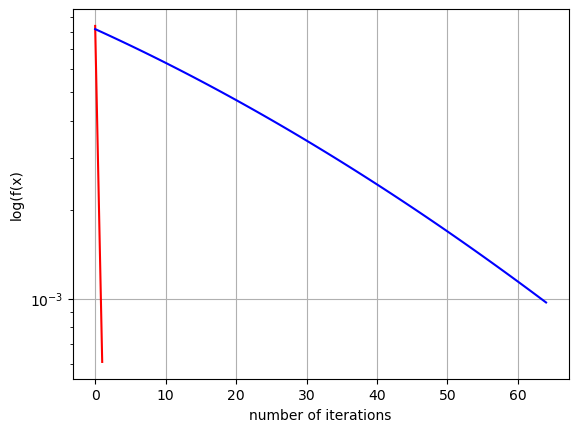

In [27]:
plt.style.use('default')
plt.plot(fXX, 'r', label = 'FINDER')
plt.plot(fx_st,'b', label = 'Adam')
plt.yscale('log')
plt.xlabel("number of iterations")
# plt.title("{} function {} steps {} seconds time".format(str(strfitnessfct).split()[1], it,np.round(toc - tic,3)))
plt.ylabel("log(f(x)")
plt.grid()
plt.show()